In [1]:
%%capture
%pip install opencv-python
%pip install scikit-image

In [2]:
%matplotlib inline
import cv2
import scipy
import skimage
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

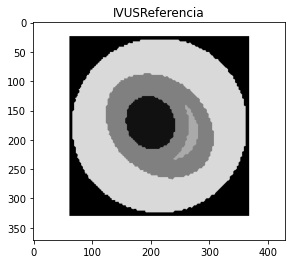

In [3]:
ivus_referencia = skimage.img_as_float(cv2.imread('../imagens/IVUSReferencia.pgm', 0))
plt.figure()
plt.title('IVUSReferencia')
plt.imshow(ivus_referencia, cmap='gray')

---
# <center> Questão 1: segmentação sem ruído <center>

In [9]:
roi = cv2.selectROI(ivus_referencia)

In [10]:
c_min = roi[0]
l_min = roi[1]
c_max = roi[0] + roi[2]
l_max = roi[1] + roi[3]
variancia_homogenia = np.var(ivus_referencia[l_min:l_max, c_min:c_max])
media = np.mean(ivus_referencia[l_min:l_max, c_min:c_max])
desvio_padrao = np.std(ivus_referencia[l_min:l_max, c_min:c_max])

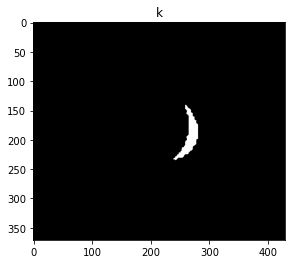

In [11]:
(M,N) = np.shape(ivus_referencia)
k = np.zeros((M,N),float)
for m in range(M):
    for n in range(N):
        if (ivus_referencia[m,n] >= media-desvio_padrao) and (ivus_referencia[m,n] <= media+desvio_padrao):
            k[m,n] = ivus_referencia[m,n]

plt.figure()
plt.title('k')
plt.imshow(k, cmap='gray')

---
# <center> Questão 2: Avaliação </center>
Para fazer a avaliação de segmentação, faça o seguinte:
a. Transforme a imagem com a informação extraída e TAMBÉM a imagem
“ObjetoGoldStandard.pgm” em binárias.

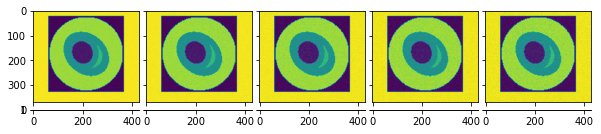

In [4]:
f_noise = list()
fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 5),
                 axes_pad=0.1,
                 )
for i in range(1, 6):
    f_noise.append(
        skimage.util.random_noise(
            image=ivus_referencia,
            var=i*0.001,
            mode='gaussian',
        )
    )
    grid[i-1].imshow(f_noise[i-1])

## Plotando objeto de referência

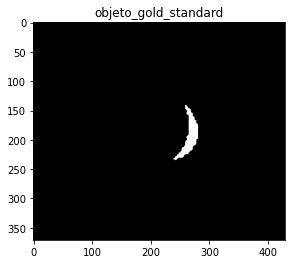

In [39]:
objeto_gold_standard = skimage.img_as_float(cv2.imread('../imagens/ObjetoGoldStandard.pgm', 0))
plt.figure()
plt.title('objeto_gold_standard')
plt.imshow(objeto_gold_standard, cmap='gray')

In [40]:
threshold = 0.5
objeto_gold_standard_bin = objeto_gold_standard > threshold
thresh = skimage.filters.threshold_otsu(objeto_gold_standard)

In [37]:
def fazer_avaliacao_segmentacao(objeto_segmentado: np.array, gold_standard: np.array) -> tuple:
    objeto_segmentado: np.array = objeto_segmentado > 0.5
    gold_standard: np.array = gold_standard > 0.5
    (M, N) = np.shape(objeto_segmentado)
    area_imagem = M*N
    area_objeto_segmentado = np.sum(objeto_segmentado)
    area_objeto_gold_standard = np.sum(gold_standard)
    area_interseccao = np.sum(objeto_segmentado & gold_standard)
    VP = 100 * (area_interseccao / area_objeto_gold_standard)
    FP = 100 * (area_objeto_segmentado - area_interseccao) / (area_imagem-area_objeto_gold_standard)
    FN = 100 * (area_objeto_gold_standard - area_interseccao) / area_imagem
    return (VP, FP, FN)

In [16]:
fazer_avaliacao_segmentacao(k, objeto_gold_standard_bin)

(100.0, 0.0, 0.0)

---
## <center> Questão 2b </center>
Faça uma função para fazer avaliação de segmentação, na qual o usuário
entra com o objeto binário segmentado e o Gold Standard e a função
devolve um vetor [Resultado] com os valores de Verdadeiros Positivos
(VP(%)), Falsos Positivos (FP(%)), Falsos Negativos(FN(%)).

In [32]:
ruidos_segmentados = [cv2.selectROI(windowName=f'ruido {i*0.1}', img=image) for i, image in enumerate(f_noise)]

In [33]:
ruidos_segmentados

[(270, 186, 6, 6),
 (270, 190, 7, 6),
 (269, 187, 9, 11),
 (268, 190, 7, 7),
 (268, 190, 7, 6)]

In [30]:
def calcular_parametros(roi_response: tuple, imagem_original: np.array) -> dict:
    c_min = roi_response[0]
    l_min = roi_response[1]
    c_max = roi_response[0] + roi_response[2]
    l_max = roi_response[1] + roi_response[3]
    variancia_homogenia = np.var(imagem_original[l_min:l_max, c_min:c_max])
    media = np.mean(imagem_original[l_min:l_max, c_min:c_max])
    desvio_padrao = np.std(imagem_original[l_min:l_max, c_min:c_max])
    (M,N) = np.shape(imagem_original)
    k = np.zeros((M,N),float)
    for m in range(M):
        for n in range(N):
            if (imagem_original[m,n] >= media-desvio_padrao) and (imagem_original[m,n] <= media+desvio_padrao):
                k[m,n] = imagem_original[m,n]
    return {'img_segmentada': k, 'metricas': [variancia_homogenia, media, desvio_padrao]}

In [42]:
x = f_noise[0]
y = ruidos_segmentados[0]
z = calcular_parametros(y, x)

In [43]:
z

{'img_segmentada': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'metricas': [0.001347500752513381, 0.6717399648899985, 0.03670831993585897]}

In [44]:
z = [calcular_parametros(ruidos_segmentados[index], img) for index, img in enumerate(f_noise)]

In [45]:
z

[{'img_segmentada': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'metricas': [0.001347500752513381, 0.6717399648899985, 0.03670831993585897]},
 {'img_segmentada': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'metricas': [0.00153602708892383, 0.6733706167401193, 0.03919218147697102]},
 {'img_segmentada': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'metricas': [0.00

---
# <center> Questão 3 </center>
Imagens com ruído sem pré e pós

0.1: 
        (VP, FP, FN): (74.96050552922591, 0.0, 0.19917189728510484) 
        dp: 0.03670831993585897 
        m: 0.6717399648899985 
        v: 0.001347500752513381
0.2: 
        (VP, FP, FN): (61.92733017377567, 0.043067140405211125, 0.30284181227577456) 
        dp: 0.03919218147697102 
        m: 0.6733706167401193 
        v: 0.00153602708892383
0.3: 
        (VP, FP, FN): (66.74565560821485, 0.4819719683583186, 0.2645153588549815) 
        dp: 0.052444288492614836 
        m: 0.6571547422791763 
        v: 0.0027504033954966127
0.4: 
        (VP, FP, FN): (73.45971563981043, 1.7068521087065291, 0.2111096450719092) 
        dp: 0.07086483693689385 
        m: 0.6554298474783097 
        v: 0.005021825114092556
0.5: 
        (VP, FP, FN): (65.00789889415482, 2.955165840157575, 0.27833801418707077) 
        dp: 0.0667149733840401 
        m: 0.6888284777176367 
        v: 0.004450887673633179


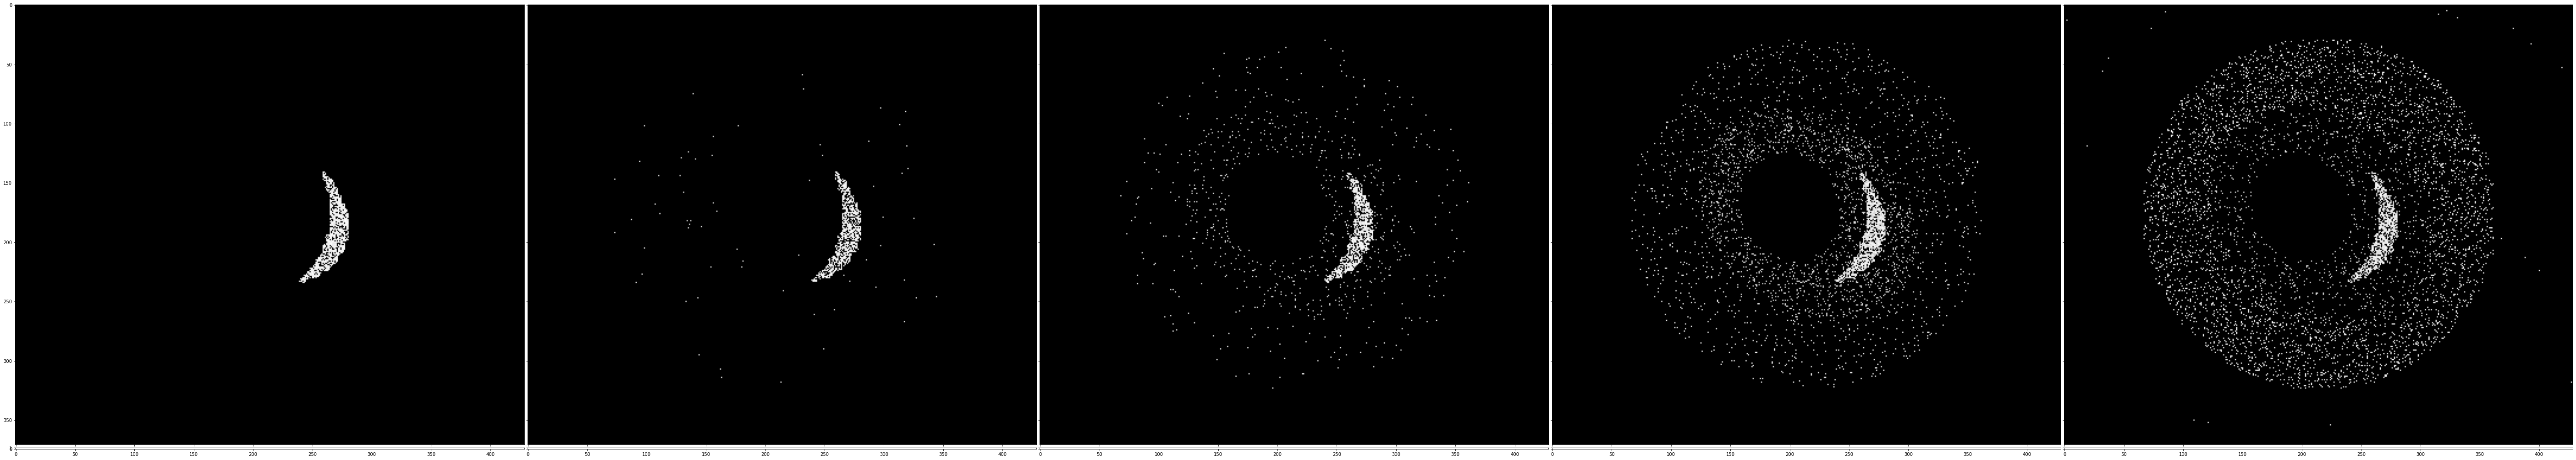

In [46]:
fig2 = plt.figure(1, (100., 100.))
grid2 = ImageGrid(fig2, 111,
                nrows_ncols=(2, 5),
                axes_pad=0.1,
                )
for i, img_segmentada in enumerate(z):
    imagem = img_segmentada.get('img_segmentada', None)
    metricas = img_segmentada.get('metricas', None)
    resultado = fazer_avaliacao_segmentacao(imagem, objeto_gold_standard_bin)
    print(
        f'{round((i+1)*0.1, ndigits=2)}: \n\
        (VP, FP, FN): {resultado} \n\
        dp: {metricas[2]} \n\
        m: {metricas[1]} \n\
        v: {metricas[0]}'
    )

    grid2[i].imshow(imagem, cmap='gray')

---
# <center> Questão 4 </center>
Pré-processamento → , Adicione uma etapa de pré-processamento neste
método de segmentação, use o melhor filtro do sua avaliação.

In [47]:
def fazer_mascara_gaussiana_2d(m, n, fc):
    h_gauss = np.zeros((m,n), complex)
    d0 = fc * (m/2)
    for l in range(m):
        for c in range(n):
            dist_c = c - (n/2)
            dist_l = l - (m/2)
            d = np.sqrt((dist_c ** 2) + (dist_l ** 2))
            h_gauss[l,c] = np.exp(-((d**2)/((2*d0) ** 2))) + 0j
    return h_gauss

def filtragem_alta_gaussiana(img, fc):
    (M, N) = np.shape(img)
    h_gauss = fazer_mascara_gaussiana_2d(M, N, fc)
    img_filt = np.fft.ifft2(np.fft.fft2(img) * (1-h_gauss))
    return img_filt

def filtragem_baixa_gaussiana(img, fc):
    (M, N) = np.shape(img)
    h_gauss = fazer_mascara_gaussiana_2d(M, N, fc)
    img_filt = np.fft.ifft2(np.fft.fft2(img) * h_gauss)
    return img_filt

Aplicando passa-alta

In [34]:
ruido_filtrado = [filtragem_alta_gaussiana(img, 1) for img in f_noise]
z_filtrado = [calcular_parametros(ruidos_segmentados[index], img) for index, img in enumerate(ruido_filtrado)]

C:\Users\caiom\AppData\Local\Temp\ipykernel_10156\1000181552.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  k[m,n] = imagem_original[m,n]


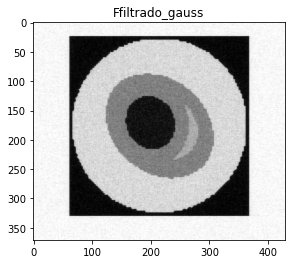

In [17]:
plt.figure()
plt.title('Ffiltrado_gauss')
plt.imshow(np.abs(ruido_filtrado[4]), cmap='gray')

0.1: 
        (VP, FP, FN): (0.0, 0.0, 0.7954309841102294) 
        dp: 0.0068483643309712235 
        m: (0.29567621693438656+1.4873404690683946e-17j) 
        v: 4.690009400971893e-05
0.2: 
        (VP, FP, FN): (0.0, 0.0, 0.7954309841102294) 
        dp: 0.007615213213638534 
        m: (0.2962187623728859-7.26543973684771e-18j) 
        v: 5.799147228917493e-05
0.3: 
        (VP, FP, FN): (0.0, 0.0, 0.7954309841102294) 
        dp: 0.010860519996164303 
        m: (0.28967471510979603-1.255102647285743e-17j) 
        v: 0.00011795089458708466
0.4: 
        (VP, FP, FN): (0.0, 0.0, 0.7954309841102294) 
        dp: 0.01531502313973683 
        m: (0.28920296016513086-2.9570703960878243e-17j) 
        v: 0.00023454993377067455
0.5: 
        (VP, FP, FN): (0.0, 0.0, 0.7954309841102294) 
        dp: 0.012770553177784347 
        m: (0.3015037543635382+2.4108021854826088e-17j) 
        v: 0.00016308702846661786


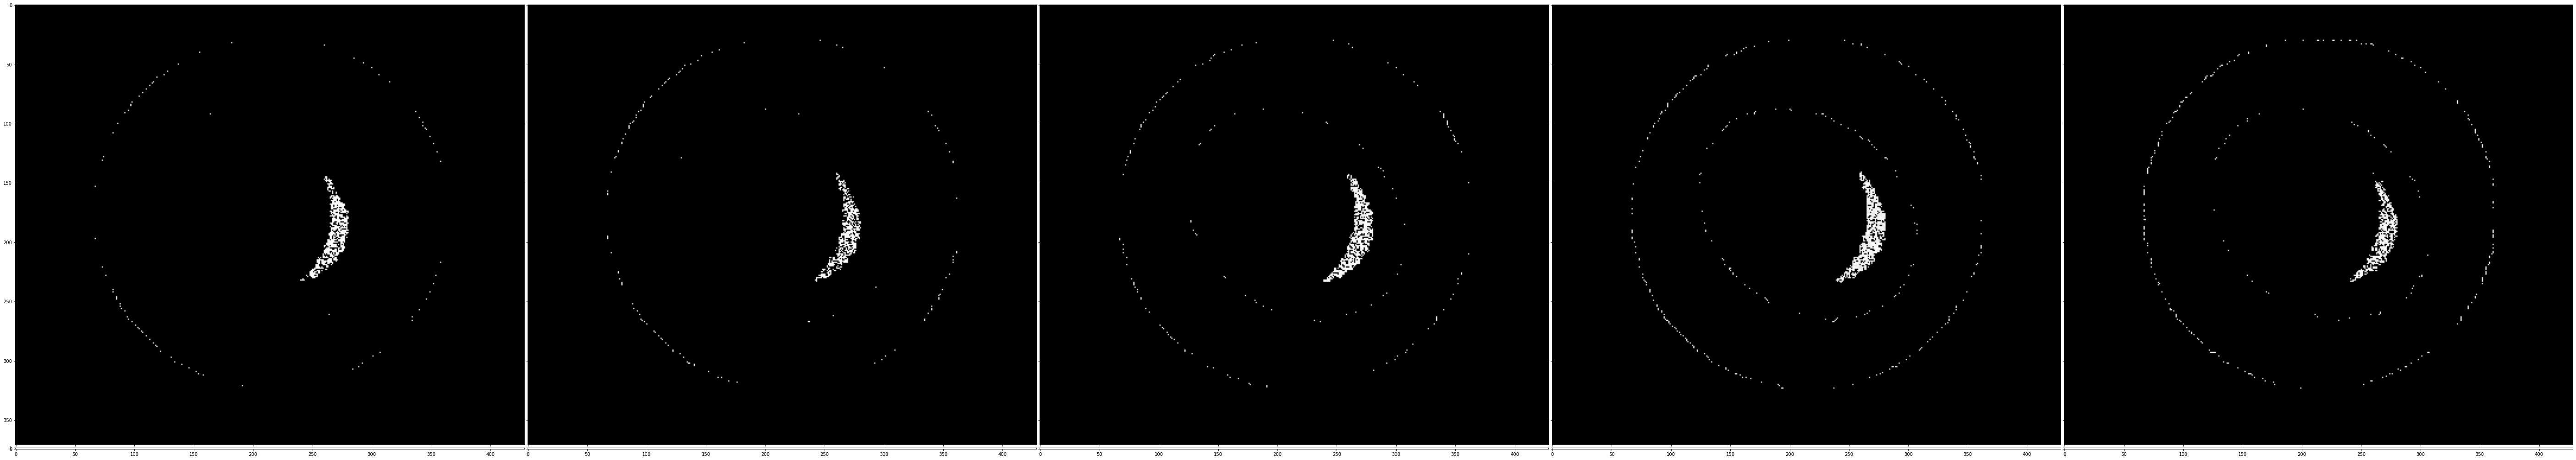

In [41]:
fig3 = plt.figure(1, (100., 100.))
grid3 = ImageGrid(fig3, 111,
                nrows_ncols=(2, 5),
                axes_pad=0.1,
                )
for i, img_segmentada in enumerate(z_filtrado):
    imagem = img_segmentada.get('img_segmentada', None)
    metricas = img_segmentada.get('metricas', None)
    resultado_filtrado = fazer_avaliacao_segmentacao(imagem, objeto_gold_standard_bin)
    print(
        f'{round((i+1)*0.1, ndigits=2)}: \n\
        (VP, FP, FN): {resultado_filtrado} \n\
        dp: {metricas[2]} \n\
        m: {metricas[1]} \n\
        v: {metricas[0]}'
    )

    grid3[i].imshow(imagem, cmap='gray')

---
# Questão 5
Pós-processamento → Adicione uma etapa de pós-processamento, use
operações morfológicas de fechamento e abertura (ver obs.), com diferentes
elementos estruturantes, quadrado e circular, de tamanho 5x5.

In [24]:
img_frequencia = cv2.resize(f_noise[4], (400,400), interpolation = cv2.INTER_AREA)
pulso_frequencia = np.fft.fft2(img_frequencia)
frequencia_deslocado = np.fft.fftshift(pulso_frequencia)